#### Install MMPose
We recommend to use a conda environment to install mmpose and its dependencies. And compilers nvcc and gcc are required.

In [1]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/userhome/cs/nickwang/anaconda3/bin/python


In [11]:
# install pytorch
!pip install torch

# install mmcv-full. Please follow the instruction (https://github.com/open-mmlab/mmcv) to install mmcv-full.
!pip install mmcv-full==1.3.18 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html

# install mmdet for inference demo
!pip install mmdet

# clone mmpose repo
!rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git

# clone necessary files for this assignment
!rm -rf COMP7606
!git clone https://github.com/jin-s13/COMP7606.git

%cd mmpose

# install mmpose dependencies
!pip install -r requirements.txt

# install mmpose in develop mode
!pip install -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
Cloning into 'mmpose'...
remote: Enumerating objects: 17932, done.
remote: Counting objects: 100% (2856/2856), done.
remote: Compressing objects: 100% (1144/1144), done.
remote: Total 17932 (delta 1864), reused 2413 (delta 1680), pack-reused 15076
Receiving objects: 100% (17932/17932), 26.12 MiB | 11.11 MiB/s, done.
Resolving deltas: 100% (12459/12459), done.
Checking out files: 100% (1483/1483), done.
Cloning into 'COMP7606'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.
/userhome/cs/nickwang/mmpose
Ignoring dataclasses: markers 'python_version == "3.6"' don't match your environment
Obtaining file:///userhome/cs/nickwang/mmpose
  Running setup.py develop for mmpose


In [1]:
# Check Pytorch installation
import torch, torchvision
print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose
print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 1.10.2+cu102 True
torchvision version: 0.11.3+cu102
mmpose version: 0.24.0
cuda version: 10.2
compiler information: GCC 7.3


In [2]:
%cd mmpose
%ls

/userhome/cs/nickwang/mmpose
CITATION.cff  README_CN.md  docs/             requirements/     tests/
INFO          configs/      mmpose/           requirements.txt  tools/
LICENSE       data/         mmpose.egg-info/  resources/        work_dirs/
MANIFEST.in   demo/         model-index.yml   setup.cfg
README.md     docker/       pytest.ini        setup.py


In [6]:
!pip install tensorboard tensorboardX

#### Train a cat pose estimation model
To train a cat pose estimation model on a customized dataset with MMPose, there are usually three steps:

Support the dataset in MMPose
Create a config
Perform training and evaluation
##### Add a new dataset
There are two methods to support a customized dataset in MMPose. The first one is to convert the data to a supported format (e.g. COCO) and use the corresponding dataset class (e.g. TopdownCOCODataset), as described in the document. The second one is to add a new dataset class. In this tutorial, we give an example of the second method.

We first download the dataset, which contains 1328 images (1000 for training, 128 for validation and 200 for testing).

In [13]:
# download dataset
%mkdir data
%mkdir data/cats
%cp ../COMP7606/Cats.tar data/cats
%cd data/cats
!tar -xf Cats.tar
%cd ../../

/userhome/cs/nickwang/mmpose/data/cats
/userhome/cs/nickwang/mmpose


In [14]:
# The <_base_/cats.py> contains the dataset information, i.e. the keypoint definition, flip pairs, and sigmas for evaluation.
!cp ../COMP7606/configs/_base_/cats.py configs/_base_/datasets/ 
# The <configs/cats/res50_cats_128x128.py> is a baseline config file. You can use this to train/evaluate the model. 
# But the performance of the baseline model is not good enough. You should try to improve it!
!cp -r ../COMP7606/configs/cats configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ 

After downloading the data, we implement a new dataset class to load data samples for model training and validation. In this assignment, we are going to train a top-down pose estimation model (refer to Top-down Pose Estimation for a brief introduction), the new dataset class inherits AnimalAP10KDataset.

In [3]:
import json
import os
import os.path as osp
from collections import OrderedDict

import numpy as np

from mmpose.core.evaluation.top_down_eval import (keypoint_nme,
                                                  keypoint_pck_accuracy)
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.animal import AnimalAP10KDataset


@DATASETS.register_module()
class AnimalCatsDataset(AnimalAP10KDataset):

	def __init__(self,
				 ann_file,
				 img_prefix,
				 data_cfg,
				 pipeline,
				 dataset_info=None,
				 test_mode=False):
		super().__init__(
			ann_file, img_prefix, data_cfg, pipeline, dataset_info, test_mode=test_mode)

#### Create a training config file
In the next step, we create a config file which configures the model, dataset and runtime settings. More information can be found at Learn about Configs. A common practice to create a config file is deriving from a existing one. In this tutorial, we load a config file that trains a ResNet on COCO dataset, and modify it to adapt to the Cats dataset.

Note that the following config file is just an example to show how to train a model. This config file is far from optimal and the baseline model is not good enough. You should try your best to improve it.

In [4]:
from mmcv import Config
cfg = Config.fromfile(
    './configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
)

# set basic configs
cfg.data_root = 'data/cats'
cfg.work_dir = 'work_dirs/res50_cats_128x128'
cfg.gpu_ids = range(1)
cfg.seed = 0

# set log interval
cfg.log_config.interval = 1

# set evaluation configs
cfg.evaluation.interval = 5

# set batch size
cfg.data.samples_per_gpu = 32
cfg.data.val_dataloader = dict(samples_per_gpu=32)
cfg.data.test_dataloader = dict(samples_per_gpu=32)


# set dataset configs
cfg.data.train.type = 'AnimalCatsDataset'
cfg.data.train.ann_file = f'{cfg.data_root}/annotations/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.type = 'AnimalCatsDataset'
cfg.data.val.ann_file = f'{cfg.data_root}/annotations/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'

cfg.data.test.type = 'AnimalCatsDataset'
cfg.data.test.ann_file = f'{cfg.data_root}/annotations/test_info.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'

print(cfg.pretty_text)

dataset_info = dict(
    dataset_name='cats',
    paper_info=dict(
        title='Assignment for COMP7606',
        year='2022',
        homepage='https://github.com/jin-s13/COMP7606'),
    keypoint_info=dict({
        0:
        dict(
            name='L_Eye', id=0, color=[0, 255, 0], type='upper', swap='R_Eye'),
        1:
        dict(
            name='R_Eye',
            id=1,
            color=[255, 128, 0],
            type='upper',
            swap='L_Eye'),
        2:
        dict(name='Nose', id=2, color=[51, 153, 255], type='upper', swap=''),
        3:
        dict(name='Neck', id=3, color=[51, 153, 255], type='upper', swap=''),
        4:
        dict(
            name='Root of tail',
            id=4,
            color=[51, 153, 255],
            type='lower',
            swap=''),
        5:
        dict(
            name='L_Shoulder',
            id=5,
            color=[51, 153, 255],
            type='upper',
            swap='R_Shoulder'),
        6:
        dict(
  

#### Train and Evaluation

In [5]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv

# build dataset
datasets = [build_dataset(cfg.data.train)]

# build model
model = build_posenet(cfg.model)

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(
    model, datasets, cfg, distributed=False, validate=True, meta=dict())

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
=> num_images: 1000
=> load 1104 samples
load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth


2022-03-20 13:54:06,268 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
=> num_images: 124
=> load 132 samples


2022-03-20 13:55:08,131 - mmpose - INFO - Epoch [1][1/35]	lr: 5.000e-07, eta: 10:12:51, time: 5.004, data_time: 4.218, memory: 6289, heatmap_loss: 0.0012, acc_pose: 0.0333, loss: 0.0012
2022-03-20 13:55:08,679 - mmpose - INFO - Epoch [1][2/35]	lr: 1.499e-06, eta: 5:39:55, time: 0.548, data_time: 0.008, memory: 6622, heatmap_loss: 0.0011, acc_pose: 0.0143, loss: 0.0011
2022-03-20 13:55:09,282 - mmpose - INFO - Epoch [1][3/35]	lr: 2.498e-06, eta: 4:11:13, time: 0.603, data_time: 0.010, memory: 6622, heatmap_loss: 0.0014, acc_pose: 0.0255, loss: 0.0014
2022-03-20 13:55:09,828 - mmpose - INFO - Epoch [1][4/35]	lr: 3.497e-06, eta: 3:25:05, time: 0.546, data_time: 0.006, memory: 6622, heatmap_loss: 0.0013, acc_pose: 0.0565, loss: 0.0013
2022-03-20 13:55:16,745 - mmpose - INFO - Epoch [1][5/35]	lr: 4.496e-06, eta: 5:33:24, time: 6.918, data_time: 6.367, memory: 6622, heatmap_loss: 0.0013, acc_pose: 0.0472, loss: 0.0013
2022-03-20 13:55:17,267 - mmpose - INFO - Epoch [1][6/35]	lr: 5.495e-06, e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 23.4 task/s, elapsed: 6s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.232
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.691
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.309
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.742
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.182
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 13:57:44,628 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_5.pth.
2022-03-20 13:57:44,630 - mmpose - INFO - Best AP is 0.2317 at 5 epoch.
2022-03-20 13:57:44,631 - mmpose - INFO - Epoch(val) [5][5]	AP: 0.2317, AP .5: 0.6911, AP .75: 0.0999, AP (M): 0.0432, AP (L): 0.2330, AR: 0.3091, AR .5: 0.7424, AR .75: 0.1818, AR (M): 0.1600, AR (L): 0.3119
2022-03-20 13:57:48,448 - mmpose - INFO - Epoch [6][1/35]	lr: 1.753e-04, eta: 1:39:05, time: 3.804, data_time: 3.200, memory: 6622, heatmap_loss: 0.0010, acc_pose: 0.3222, loss: 0.0010
2022-03-20 13:57:49,000 - mmpose - INFO - Epoch [6][2/35]	lr: 1.763e-04, eta: 1:38:53, time: 0.552, data_time: 0.009, memory: 6622, heatmap_loss: 0.0009, acc_pose: 0.2526, loss: 0.0009
2022-03-20 13:57:50,250 - mmpose - INFO - Epoch [6][3/35]	lr: 1.773e-04, eta: 1:39:09, time: 1.250, data_time: 0.719, memory: 6622, heatmap_loss: 0.0010, acc_pose: 0.3068, loss: 0.0010
2022-03-20 13:57:50,780 - mmpose - INFO - Epoch [6][4/35]	lr: 1.783e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 69.3 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.438
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.868
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.523
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.902
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.530
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 13:59:44,177 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_5.pth was removed
2022-03-20 13:59:45,507 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_10.pth.
2022-03-20 13:59:45,509 - mmpose - INFO - Best AP is 0.4383 at 10 epoch.
2022-03-20 13:59:45,511 - mmpose - INFO - Epoch(val) [10][5]	AP: 0.4383, AP .5: 0.8680, AP .75: 0.3823, AP (M): 0.1436, AP (L): 0.4371, AR: 0.5227, AR .5: 0.9015, AR .75: 0.5303, AR (M): 0.5000, AR (L): 0.5246
2022-03-20 13:59:49,286 - mmpose - INFO - Epoch [11][1/35]	lr: 3.501e-04, eta: 1:24:26, time: 3.761, data_time: 3.056, memory: 6622, heatmap_loss: 0.0008, acc_pose: 0.4170, loss: 0.0008
2022-03-20 13:59:49,887 - mmpose - INFO - Epoch [11][2/35]	lr: 3.511e-04, eta: 1:24:23, time: 0.601, data_time: 0.013, memory: 6622, heatmap_loss: 0.0008, acc_pose: 0.3881, loss: 0.0008
2022-03-20 13:59:50,431 - mmpose - INFO - Epoch [11][3/35]	lr: 3.521e-04, eta: 1:24:19, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 14:01:43,882 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_10.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.870
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.474
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.577
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.909
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.576


2022-03-20 14:01:45,322 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_15.pth.
2022-03-20 14:01:45,324 - mmpose - INFO - Best AP is 0.4849 at 15 epoch.
2022-03-20 14:01:45,326 - mmpose - INFO - Epoch(val) [15][5]	AP: 0.4849, AP .5: 0.8703, AP .75: 0.4736, AP (M): 0.1846, AP (L): 0.4808, AR: 0.5773, AR .5: 0.9091, AR .75: 0.6061, AR (M): 0.5800, AR (L): 0.5762
2022-03-20 14:01:49,160 - mmpose - INFO - Epoch [16][1/35]	lr: 5.000e-04, eta: 1:18:25, time: 3.820, data_time: 3.181, memory: 6622, heatmap_loss: 0.0007, acc_pose: 0.4765, loss: 0.0007
2022-03-20 14:01:49,736 - mmpose - INFO - Epoch [16][2/35]	lr: 5.000e-04, eta: 1:18:22, time: 0.577, data_time: 0.017, memory: 6622, heatmap_loss: 0.0007, acc_pose: 0.4760, loss: 0.0007
2022-03-20 14:01:50,267 - mmpose - INFO - Epoch [16][3/35]	lr: 5.000e-04, eta: 1:18:20, time: 0.532, data_time: 0.005, memory: 6622, heatmap_loss: 0.0009, acc_pose: 0.4149, loss: 0.0009
2022-03-20 14:01:50,803 - mmpose - INFO - Epoch [16][4/35]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 51.2 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-20 14:03:47,143 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_15.pth was removed


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.553
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.904
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.632
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.633


2022-03-20 14:03:48,691 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_20.pth.
2022-03-20 14:03:48,693 - mmpose - INFO - Best AP is 0.5526 at 20 epoch.
2022-03-20 14:03:48,695 - mmpose - INFO - Epoch(val) [20][5]	AP: 0.5526, AP .5: 0.9036, AP .75: 0.5649, AP (M): 0.2531, AP (L): 0.5495, AR: 0.6318, AR .5: 0.9242, AR .75: 0.6667, AR (M): 0.6000, AR (L): 0.6325
2022-03-20 14:03:52,528 - mmpose - INFO - Epoch [21][1/35]	lr: 5.000e-04, eta: 1:14:31, time: 3.812, data_time: 3.237, memory: 6622, heatmap_loss: 0.0007, acc_pose: 0.4965, loss: 0.0007
2022-03-20 14:03:53,068 - mmpose - INFO - Epoch [21][2/35]	lr: 5.000e-04, eta: 1:14:29, time: 0.541, data_time: 0.017, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.5597, loss: 0.0006
2022-03-20 14:03:53,588 - mmpose - INFO - Epoch [21][3/35]	lr: 5.000e-04, eta: 1:14:27, time: 0.520, data_time: 0.008, memory: 6622, heatmap_loss: 0.0007, acc_pose: 0.5221, loss: 0.0007
2022-03-20 14:03:54,175 - mmpose - INFO - Epoch [21][4/35]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.7 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.909
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.569
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.647
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.939
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.697
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:05:55,244 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_20.pth was removed
2022-03-20 14:05:56,626 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_25.pth.
2022-03-20 14:05:56,627 - mmpose - INFO - Best AP is 0.5546 at 25 epoch.
2022-03-20 14:05:56,628 - mmpose - INFO - Epoch(val) [25][5]	AP: 0.5546, AP .5: 0.9093, AP .75: 0.5689, AP (M): 0.2227, AP (L): 0.5493, AR: 0.6470, AR .5: 0.9394, AR .75: 0.6970, AR (M): 0.6600, AR (L): 0.6452
2022-03-20 14:06:00,400 - mmpose - INFO - Epoch [26][1/35]	lr: 5.000e-04, eta: 1:11:57, time: 3.761, data_time: 3.226, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.6324, loss: 0.0006
2022-03-20 14:06:00,995 - mmpose - INFO - Epoch [26][2/35]	lr: 5.000e-04, eta: 1:11:55, time: 0.595, data_time: 0.012, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.6455, loss: 0.0006
2022-03-20 14:06:01,547 - mmpose - INFO - Epoch [26][3/35]	lr: 5.000e-04, eta: 1:11:54,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.942
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.636
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.682
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:08:00,868 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_25.pth was removed
2022-03-20 14:08:03,463 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_30.pth.
2022-03-20 14:08:03,465 - mmpose - INFO - Best AP is 0.5999 at 30 epoch.
2022-03-20 14:08:03,466 - mmpose - INFO - Epoch(val) [30][5]	AP: 0.5999, AP .5: 0.9419, AP .75: 0.6363, AP (M): 0.3547, AP (L): 0.5961, AR: 0.6818, AR .5: 0.9545, AR .75: 0.7348, AR (M): 0.6800, AR (L): 0.6817
2022-03-20 14:08:07,229 - mmpose - INFO - Epoch [31][1/35]	lr: 5.000e-04, eta: 1:09:23, time: 3.744, data_time: 3.117, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.5272, loss: 0.0006
2022-03-20 14:08:07,836 - mmpose - INFO - Epoch [31][2/35]	lr: 5.000e-04, eta: 1:09:22, time: 0.609, data_time: 0.012, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.6139, loss: 0.0006
2022-03-20 14:08:08,383 - mmpose - INFO - Epoch [31][3/35]	lr: 5.000e-04, eta: 1:09:21,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 68.4 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.577
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.638
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.667
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:10:06,529 - mmpose - INFO - Epoch(val) [35][5]	AP: 0.5766, AP .5: 0.9350, AP .75: 0.6383, AP (M): 0.2747, AP (L): 0.5730, AR: 0.6674, AR .5: 0.9545, AR .75: 0.7348, AR (M): 0.7000, AR (L): 0.6651
2022-03-20 14:10:10,278 - mmpose - INFO - Epoch [36][1/35]	lr: 5.000e-04, eta: 1:07:03, time: 3.736, data_time: 3.094, memory: 6622, heatmap_loss: 0.0007, acc_pose: 0.6002, loss: 0.0007
2022-03-20 14:10:10,854 - mmpose - INFO - Epoch [36][2/35]	lr: 5.000e-04, eta: 1:07:02, time: 0.576, data_time: 0.014, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7540, loss: 0.0005
2022-03-20 14:10:11,392 - mmpose - INFO - Epoch [36][3/35]	lr: 5.000e-04, eta: 1:07:01, time: 0.538, data_time: 0.005, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.6639, loss: 0.0006
2022-03-20 14:10:11,895 - mmpose - INFO - Epoch [36][4/35]	lr: 5.000e-04, eta: 1:07:00, time: 0.503, data_time: 0.005, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.5617, loss: 0.0006
2022-03-20 14:10:12,440 - mmpose - INFO - Epoc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 64.4 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 14:12:06,285 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_30.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.605
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.925
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.663
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.675
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.675


2022-03-20 14:12:07,654 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_40.pth.
2022-03-20 14:12:07,656 - mmpose - INFO - Best AP is 0.6052 at 40 epoch.
2022-03-20 14:12:07,658 - mmpose - INFO - Epoch(val) [40][5]	AP: 0.6052, AP .5: 0.9253, AP .75: 0.6626, AP (M): 0.2645, AP (L): 0.6037, AR: 0.6750, AR .5: 0.9470, AR .75: 0.7348, AR (M): 0.6800, AR (L): 0.6746
2022-03-20 14:12:11,374 - mmpose - INFO - Epoch [41][1/35]	lr: 5.000e-04, eta: 1:04:42, time: 3.699, data_time: 2.973, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.7011, loss: 0.0006
2022-03-20 14:12:11,945 - mmpose - INFO - Epoch [41][2/35]	lr: 5.000e-04, eta: 1:04:41, time: 0.573, data_time: 0.017, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.6413, loss: 0.0005
2022-03-20 14:12:12,483 - mmpose - INFO - Epoch [41][3/35]	lr: 5.000e-04, eta: 1:04:40, time: 0.538, data_time: 0.008, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.7111, loss: 0.0006
2022-03-20 14:12:13,012 - mmpose - INFO - Epoch [41][4/35]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 64.5 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.606
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.950
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.683
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.687
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.765
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:14:06,868 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_40.pth was removed
2022-03-20 14:14:08,664 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_45.pth.
2022-03-20 14:14:08,665 - mmpose - INFO - Best AP is 0.6061 at 45 epoch.
2022-03-20 14:14:08,666 - mmpose - INFO - Epoch(val) [45][5]	AP: 0.6061, AP .5: 0.9503, AP .75: 0.6827, AP (M): 0.2845, AP (L): 0.6046, AR: 0.6871, AR .5: 0.9621, AR .75: 0.7652, AR (M): 0.6600, AR (L): 0.6873
2022-03-20 14:14:12,311 - mmpose - INFO - Epoch [46][1/35]	lr: 5.000e-04, eta: 1:02:27, time: 3.632, data_time: 3.071, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.6357, loss: 0.0005
2022-03-20 14:14:12,828 - mmpose - INFO - Epoch [46][2/35]	lr: 5.000e-04, eta: 1:02:26, time: 0.517, data_time: 0.013, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7043, loss: 0.0005
2022-03-20 14:14:13,353 - mmpose - INFO - Epoch [46][3/35]	lr: 5.000e-04, eta: 1:02:25,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 61.3 task/s, elapsed: 2s, ETA:     0s

2022-03-20 14:16:20,139 - mmpose - INFO - Epoch(val) [50][5]	AP: 0.5812, AP .5: 0.8888, AP .75: 0.6096, AP (M): 0.2713, AP (L): 0.5815, AR: 0.6667, AR .5: 0.9167, AR .75: 0.7197, AR (M): 0.6600, AR (L): 0.6690


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.581
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.889
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.667
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.917
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-20 14:16:23,872 - mmpose - INFO - Epoch [51][1/35]	lr: 5.000e-04, eta: 1:00:54, time: 3.723, data_time: 3.132, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.6862, loss: 0.0005
2022-03-20 14:16:24,478 - mmpose - INFO - Epoch [51][2/35]	lr: 5.000e-04, eta: 1:00:53, time: 0.606, data_time: 0.018, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7082, loss: 0.0004
2022-03-20 14:16:25,027 - mmpose - INFO - Epoch [51][3/35]	lr: 5.000e-04, eta: 1:00:52, time: 0.549, data_time: 0.004, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7504, loss: 0.0005
2022-03-20 14:16:25,556 - mmpose - INFO - Epoch [51][4/35]	lr: 5.000e-04, eta: 1:00:51, time: 0.529, data_time: 0.005, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.6894, loss: 0.0005
2022-03-20 14:16:26,085 - mmpose - INFO - Epoch [51][5/35]	lr: 5.000e-04, eta: 1:00:50, time: 0.529, data_time: 0.005, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.7823, loss: 0.0006
2022-03-20 14:16:26,599 - mmpose - INFO - Epoch [51][6/35]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.5 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 14:18:23,199 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_45.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.616
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.951
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.681
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.690
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.765
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.690


2022-03-20 14:18:26,262 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_55.pth.
2022-03-20 14:18:26,263 - mmpose - INFO - Best AP is 0.6164 at 55 epoch.
2022-03-20 14:18:26,264 - mmpose - INFO - Epoch(val) [55][5]	AP: 0.6164, AP .5: 0.9508, AP .75: 0.6812, AP (M): 0.3149, AP (L): 0.6131, AR: 0.6902, AR .5: 0.9621, AR .75: 0.7652, AR (M): 0.7000, AR (L): 0.6905
2022-03-20 14:18:30,037 - mmpose - INFO - Epoch [56][1/35]	lr: 5.000e-04, eta: 0:58:55, time: 3.760, data_time: 3.128, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.6418, loss: 0.0006
2022-03-20 14:18:30,663 - mmpose - INFO - Epoch [56][2/35]	lr: 5.000e-04, eta: 0:58:54, time: 0.627, data_time: 0.022, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7374, loss: 0.0005
2022-03-20 14:18:31,220 - mmpose - INFO - Epoch [56][3/35]	lr: 5.000e-04, eta: 0:58:53, time: 0.557, data_time: 0.004, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7174, loss: 0.0005
2022-03-20 14:18:31,748 - mmpose - INFO - Epoch [56][4/35]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.7 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).


2022-03-20 14:20:26,501 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_55.pth was removed


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.624
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.963
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.683
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.977
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.686


2022-03-20 14:20:27,986 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_60.pth.
2022-03-20 14:20:27,988 - mmpose - INFO - Best AP is 0.6243 at 60 epoch.
2022-03-20 14:20:27,990 - mmpose - INFO - Epoch(val) [60][5]	AP: 0.6243, AP .5: 0.9632, AP .75: 0.6944, AP (M): 0.4443, AP (L): 0.6241, AR: 0.6833, AR .5: 0.9773, AR .75: 0.7500, AR (M): 0.6600, AR (L): 0.6857
2022-03-20 14:20:31,834 - mmpose - INFO - Epoch [61][1/35]	lr: 5.000e-04, eta: 0:56:46, time: 3.830, data_time: 3.068, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8210, loss: 0.0004
2022-03-20 14:20:32,409 - mmpose - INFO - Epoch [61][2/35]	lr: 5.000e-04, eta: 0:56:46, time: 0.576, data_time: 0.013, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.6936, loss: 0.0005
2022-03-20 14:20:32,962 - mmpose - INFO - Epoch [61][3/35]	lr: 5.000e-04, eta: 0:56:45, time: 0.553, data_time: 0.006, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7496, loss: 0.0004
2022-03-20 14:20:33,498 - mmpose - INFO - Epoch [61][4/35]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 64.0 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.639
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.726
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.688
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.970
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.773
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:22:30,232 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_60.pth was removed
2022-03-20 14:22:31,758 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_65.pth.
2022-03-20 14:22:31,759 - mmpose - INFO - Best AP is 0.6386 at 65 epoch.
2022-03-20 14:22:31,760 - mmpose - INFO - Epoch(val) [65][5]	AP: 0.6386, AP .5: 0.9563, AP .75: 0.7255, AP (M): 0.4473, AP (L): 0.6404, AR: 0.6879, AR .5: 0.9697, AR .75: 0.7727, AR (M): 0.6600, AR (L): 0.6921
2022-03-20 14:22:35,647 - mmpose - INFO - Epoch [66][1/35]	lr: 5.000e-04, eta: 0:54:45, time: 3.876, data_time: 3.303, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7763, loss: 0.0004
2022-03-20 14:22:36,206 - mmpose - INFO - Epoch [66][2/35]	lr: 5.000e-04, eta: 0:54:44, time: 0.559, data_time: 0.008, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.6901, loss: 0.0005
2022-03-20 14:22:36,759 - mmpose - INFO - Epoch [66][3/35]	lr: 5.000e-04, eta: 0:54:43,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 70.0 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.627
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.954
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.695
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.970
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.773
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:24:32,192 - mmpose - INFO - Epoch(val) [70][5]	AP: 0.6267, AP .5: 0.9539, AP .75: 0.7116, AP (M): 0.3776, AP (L): 0.6293, AR: 0.6955, AR .5: 0.9697, AR .75: 0.7727, AR (M): 0.6400, AR (L): 0.7000
2022-03-20 14:24:35,861 - mmpose - INFO - Epoch [71][1/35]	lr: 5.000e-04, eta: 0:52:42, time: 3.656, data_time: 3.088, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.6761, loss: 0.0004
2022-03-20 14:24:36,443 - mmpose - INFO - Epoch [71][2/35]	lr: 5.000e-04, eta: 0:52:42, time: 0.583, data_time: 0.010, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7405, loss: 0.0005
2022-03-20 14:24:37,020 - mmpose - INFO - Epoch [71][3/35]	lr: 5.000e-04, eta: 0:52:41, time: 0.577, data_time: 0.009, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7792, loss: 0.0005
2022-03-20 14:24:37,571 - mmpose - INFO - Epoch [71][4/35]	lr: 5.000e-04, eta: 0:52:40, time: 0.550, data_time: 0.009, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7154, loss: 0.0005
2022-03-20 14:24:38,112 - mmpose - INFO - Epoc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.5 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).


2022-03-20 14:26:31,980 - mmpose - INFO - Epoch(val) [75][5]	AP: 0.6321, AP .5: 0.9544, AP .75: 0.7227, AP (M): 0.4257, AP (L): 0.6358, AR: 0.6864, AR .5: 0.9621, AR .75: 0.7727, AR (M): 0.6200, AR (L): 0.6921


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.632
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.954
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.723
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.686
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.692


2022-03-20 14:26:35,684 - mmpose - INFO - Epoch [76][1/35]	lr: 5.000e-04, eta: 0:50:42, time: 3.690, data_time: 3.122, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7580, loss: 0.0004
2022-03-20 14:26:36,264 - mmpose - INFO - Epoch [76][2/35]	lr: 5.000e-04, eta: 0:50:41, time: 0.581, data_time: 0.012, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7006, loss: 0.0005
2022-03-20 14:26:36,827 - mmpose - INFO - Epoch [76][3/35]	lr: 5.000e-04, eta: 0:50:40, time: 0.562, data_time: 0.014, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7828, loss: 0.0004
2022-03-20 14:26:37,372 - mmpose - INFO - Epoch [76][4/35]	lr: 5.000e-04, eta: 0:50:40, time: 0.546, data_time: 0.008, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7609, loss: 0.0005
2022-03-20 14:26:37,967 - mmpose - INFO - Epoch [76][5/35]	lr: 5.000e-04, eta: 0:50:39, time: 0.594, data_time: 0.009, memory: 6622, heatmap_loss: 0.0006, acc_pose: 0.7613, loss: 0.0006
2022-03-20 14:26:38,501 - mmpose - INFO - Epoch [76][6/35]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.3 task/s, elapsed: 2s, ETA:     0s

2022-03-20 14:28:30,898 - mmpose - INFO - Epoch(val) [80][5]	AP: 0.6286, AP .5: 0.9303, AP .75: 0.7284, AP (M): 0.2792, AP (L): 0.6285, AR: 0.6939, AR .5: 0.9470, AR .75: 0.7803, AR (M): 0.6400, AR (L): 0.6960


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.629
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.930
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.728
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.694
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-20 14:28:34,826 - mmpose - INFO - Epoch [81][1/35]	lr: 5.000e-04, eta: 0:48:43, time: 3.914, data_time: 3.290, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8083, loss: 0.0004
2022-03-20 14:28:35,405 - mmpose - INFO - Epoch [81][2/35]	lr: 5.000e-04, eta: 0:48:43, time: 0.580, data_time: 0.010, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8036, loss: 0.0003
2022-03-20 14:28:35,952 - mmpose - INFO - Epoch [81][3/35]	lr: 5.000e-04, eta: 0:48:42, time: 0.547, data_time: 0.005, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7700, loss: 0.0005
2022-03-20 14:28:36,493 - mmpose - INFO - Epoch [81][4/35]	lr: 5.000e-04, eta: 0:48:41, time: 0.540, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8107, loss: 0.0004
2022-03-20 14:28:37,038 - mmpose - INFO - Epoch [81][5/35]	lr: 5.000e-04, eta: 0:48:40, time: 0.545, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8630, loss: 0.0004
2022-03-20 14:28:37,561 - mmpose - INFO - Epoch [81][6/35]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 64.5 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-20 14:30:30,551 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_65.pth was removed


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.648
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.933
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.701


2022-03-20 14:30:32,128 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_85.pth.
2022-03-20 14:30:32,130 - mmpose - INFO - Best AP is 0.6477 at 85 epoch.
2022-03-20 14:30:32,136 - mmpose - INFO - Epoch(val) [85][5]	AP: 0.6477, AP .5: 0.9331, AP .75: 0.7306, AP (M): 0.4095, AP (L): 0.6465, AR: 0.7000, AR .5: 0.9470, AR .75: 0.7879, AR (M): 0.7000, AR (L): 0.7008
2022-03-20 14:30:35,867 - mmpose - INFO - Epoch [86][1/35]	lr: 5.000e-04, eta: 0:46:45, time: 3.717, data_time: 3.112, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7770, loss: 0.0005
2022-03-20 14:30:36,428 - mmpose - INFO - Epoch [86][2/35]	lr: 5.000e-04, eta: 0:46:44, time: 0.562, data_time: 0.011, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.7620, loss: 0.0003
2022-03-20 14:30:36,964 - mmpose - INFO - Epoch [86][3/35]	lr: 5.000e-04, eta: 0:46:43, time: 0.537, data_time: 0.008, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7960, loss: 0.0004
2022-03-20 14:30:37,510 - mmpose - INFO - Epoch [86][4/35]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.3 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.643
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.736
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.698
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.780
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:32:32,083 - mmpose - INFO - Epoch(val) [90][5]	AP: 0.6429, AP .5: 0.9347, AP .75: 0.7357, AP (M): 0.3499, AP (L): 0.6431, AR: 0.6985, AR .5: 0.9470, AR .75: 0.7803, AR (M): 0.6600, AR (L): 0.7008
2022-03-20 14:32:35,761 - mmpose - INFO - Epoch [91][1/35]	lr: 5.000e-04, eta: 0:44:48, time: 3.663, data_time: 3.022, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8644, loss: 0.0004
2022-03-20 14:32:36,490 - mmpose - INFO - Epoch [91][2/35]	lr: 5.000e-04, eta: 0:44:48, time: 0.730, data_time: 0.016, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8136, loss: 0.0004
2022-03-20 14:32:37,044 - mmpose - INFO - Epoch [91][3/35]	lr: 5.000e-04, eta: 0:44:47, time: 0.554, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7349, loss: 0.0004
2022-03-20 14:32:37,573 - mmpose - INFO - Epoch [91][4/35]	lr: 5.000e-04, eta: 0:44:46, time: 0.528, data_time: 0.004, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.7483, loss: 0.0005
2022-03-20 14:32:38,097 - mmpose - INFO - Epoc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 64.2 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.642
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.694
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.780
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:34:30,880 - mmpose - INFO - Epoch(val) [95][5]	AP: 0.6422, AP .5: 0.9558, AP .75: 0.7346, AP (M): 0.4491, AP (L): 0.6429, AR: 0.6939, AR .5: 0.9621, AR .75: 0.7803, AR (M): 0.6800, AR (L): 0.6952
2022-03-20 14:34:34,662 - mmpose - INFO - Epoch [96][1/35]	lr: 5.000e-04, eta: 0:42:52, time: 3.769, data_time: 3.132, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.6521, loss: 0.0004
2022-03-20 14:34:35,236 - mmpose - INFO - Epoch [96][2/35]	lr: 5.000e-04, eta: 0:42:51, time: 0.573, data_time: 0.017, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8373, loss: 0.0004
2022-03-20 14:34:35,774 - mmpose - INFO - Epoch [96][3/35]	lr: 5.000e-04, eta: 0:42:50, time: 0.538, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8326, loss: 0.0003
2022-03-20 14:34:36,302 - mmpose - INFO - Epoch [96][4/35]	lr: 5.000e-04, eta: 0:42:50, time: 0.528, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8149, loss: 0.0004
2022-03-20 14:34:36,828 - mmpose - INFO - Epoc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 14:36:28,423 - mmpose - INFO - Epoch(val) [100][5]	AP: 0.6334, AP .5: 0.9496, AP .75: 0.6769, AP (M): 0.3649, AP (L): 0.6381, AR: 0.7008, AR .5: 0.9697, AR .75: 0.7576, AR (M): 0.6600, AR (L): 0.7071


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.633
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.950
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.701
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.970
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.707


2022-03-20 14:36:32,049 - mmpose - INFO - Epoch [101][1/35]	lr: 5.000e-04, eta: 0:40:54, time: 3.613, data_time: 3.006, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7850, loss: 0.0004
2022-03-20 14:36:32,630 - mmpose - INFO - Epoch [101][2/35]	lr: 5.000e-04, eta: 0:40:54, time: 0.582, data_time: 0.012, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.7501, loss: 0.0003
2022-03-20 14:36:33,165 - mmpose - INFO - Epoch [101][3/35]	lr: 5.000e-04, eta: 0:40:53, time: 0.535, data_time: 0.006, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7837, loss: 0.0004
2022-03-20 14:36:33,697 - mmpose - INFO - Epoch [101][4/35]	lr: 5.000e-04, eta: 0:40:52, time: 0.532, data_time: 0.008, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8623, loss: 0.0003
2022-03-20 14:36:34,239 - mmpose - INFO - Epoch [101][5/35]	lr: 5.000e-04, eta: 0:40:52, time: 0.542, data_time: 0.009, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7994, loss: 0.0004
2022-03-20 14:36:34,781 - mmpose - INFO - Epoch [101][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 58.0 task/s, elapsed: 2s, ETA:     0s

2022-03-20 14:38:30,150 - mmpose - INFO - Epoch(val) [105][5]	AP: 0.6250, AP .5: 0.9409, AP .75: 0.7307, AP (M): 0.3607, AP (L): 0.6267, AR: 0.6886, AR .5: 0.9545, AR .75: 0.7879, AR (M): 0.7200, AR (L): 0.6929


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.625
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.689
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-20 14:38:33,941 - mmpose - INFO - Epoch [106][1/35]	lr: 5.000e-04, eta: 0:39:02, time: 3.773, data_time: 3.100, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8058, loss: 0.0003
2022-03-20 14:38:34,543 - mmpose - INFO - Epoch [106][2/35]	lr: 5.000e-04, eta: 0:39:01, time: 0.603, data_time: 0.014, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8396, loss: 0.0004
2022-03-20 14:38:35,086 - mmpose - INFO - Epoch [106][3/35]	lr: 5.000e-04, eta: 0:39:00, time: 0.543, data_time: 0.008, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8352, loss: 0.0004
2022-03-20 14:38:35,627 - mmpose - INFO - Epoch [106][4/35]	lr: 5.000e-04, eta: 0:39:00, time: 0.541, data_time: 0.006, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8120, loss: 0.0004
2022-03-20 14:38:36,172 - mmpose - INFO - Epoch [106][5/35]	lr: 5.000e-04, eta: 0:38:59, time: 0.545, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8941, loss: 0.0003
2022-03-20 14:38:36,714 - mmpose - INFO - Epoch [106][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.6 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).

2022-03-20 14:40:32,726 - mmpose - INFO - Epoch(val) [110][5]	AP: 0.6401, AP .5: 0.9579, AP .75: 0.7556, AP (M): 0.4231, AP (L): 0.6501, AR: 0.6977, AR .5: 0.9697, AR .75: 0.7955, AR (M): 0.5600, AR (L): 0.7087



 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.640
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.958
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.756
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.698
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.970
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.709


2022-03-20 14:40:36,361 - mmpose - INFO - Epoch [111][1/35]	lr: 5.000e-04, eta: 0:37:08, time: 3.623, data_time: 3.069, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8306, loss: 0.0004
2022-03-20 14:40:36,940 - mmpose - INFO - Epoch [111][2/35]	lr: 5.000e-04, eta: 0:37:07, time: 0.580, data_time: 0.008, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8235, loss: 0.0004
2022-03-20 14:40:37,454 - mmpose - INFO - Epoch [111][3/35]	lr: 5.000e-04, eta: 0:37:06, time: 0.514, data_time: 0.009, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8975, loss: 0.0003
2022-03-20 14:40:37,960 - mmpose - INFO - Epoch [111][4/35]	lr: 5.000e-04, eta: 0:37:05, time: 0.506, data_time: 0.004, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8516, loss: 0.0004
2022-03-20 14:40:38,480 - mmpose - INFO - Epoch [111][5/35]	lr: 5.000e-04, eta: 0:37:05, time: 0.520, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7891, loss: 0.0004
2022-03-20 14:40:39,026 - mmpose - INFO - Epoch [111][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.1 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.631
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.929
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.737
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.635

2022-03-20 14:42:38,578 - mmpose - INFO - Epoch(val) [115][5]	AP: 0.6308, AP .5: 0.9287, AP .75: 0.7373, AP (M): 0.4937, AP (L): 0.6352, AR: 0.6841, AR .5: 0.9394, AR .75: 0.7879, AR (M): 0.6400, AR (L): 0.6913



 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.684
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.939
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.691


2022-03-20 14:42:42,237 - mmpose - INFO - Epoch [116][1/35]	lr: 5.000e-04, eta: 0:35:17, time: 3.641, data_time: 3.029, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8290, loss: 0.0003
2022-03-20 14:42:42,812 - mmpose - INFO - Epoch [116][2/35]	lr: 5.000e-04, eta: 0:35:16, time: 0.576, data_time: 0.024, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8698, loss: 0.0003
2022-03-20 14:42:43,347 - mmpose - INFO - Epoch [116][3/35]	lr: 5.000e-04, eta: 0:35:15, time: 0.534, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8595, loss: 0.0003
2022-03-20 14:42:43,867 - mmpose - INFO - Epoch [116][4/35]	lr: 5.000e-04, eta: 0:35:15, time: 0.521, data_time: 0.007, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8304, loss: 0.0004
2022-03-20 14:42:44,392 - mmpose - INFO - Epoch [116][5/35]	lr: 5.000e-04, eta: 0:35:14, time: 0.524, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8898, loss: 0.0004
2022-03-20 14:42:44,928 - mmpose - INFO - Epoch [116][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 50.2 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.659
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.709
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.811
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:44:58,783 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_85.pth was removed
2022-03-20 14:45:00,162 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_120.pth.
2022-03-20 14:45:00,164 - mmpose - INFO - Best AP is 0.6592 at 120 epoch.
2022-03-20 14:45:00,166 - mmpose - INFO - Epoch(val) [120][5]	AP: 0.6592, AP .5: 0.9556, AP .75: 0.7701, AP (M): 0.5331, AP (L): 0.6607, AR: 0.7091, AR .5: 0.9621, AR .75: 0.8106, AR (M): 0.6800, AR (L): 0.7143
2022-03-20 14:45:03,987 - mmpose - INFO - Epoch [121][1/35]	lr: 5.000e-04, eta: 0:33:27, time: 3.804, data_time: 3.200, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.7683, loss: 0.0003
2022-03-20 14:45:04,570 - mmpose - INFO - Epoch [121][2/35]	lr: 5.000e-04, eta: 0:33:26, time: 0.584, data_time: 0.014, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7903, loss: 0.0004
2022-03-20 14:45:05,082 - mmpose - INFO - Epoch [121][3/35]	lr: 5.000e-04, eta: 0:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.1 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).


2022-03-20 14:47:17,525 - mmpose - INFO - Epoch(val) [125][5]	AP: 0.6185, AP .5: 0.9465, AP .75: 0.6619, AP (M): 0.4089, AP (L): 0.6220, AR: 0.6780, AR .5: 0.9545, AR .75: 0.7348, AR (M): 0.6600, AR (L): 0.6833


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.619
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.662
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.678
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.683


2022-03-20 14:47:21,179 - mmpose - INFO - Epoch [126][1/35]	lr: 5.000e-04, eta: 0:31:42, time: 3.637, data_time: 3.015, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8010, loss: 0.0004
2022-03-20 14:47:21,831 - mmpose - INFO - Epoch [126][2/35]	lr: 5.000e-04, eta: 0:31:42, time: 0.652, data_time: 0.023, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8431, loss: 0.0004
2022-03-20 14:47:22,365 - mmpose - INFO - Epoch [126][3/35]	lr: 5.000e-04, eta: 0:31:41, time: 0.534, data_time: 0.006, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.9025, loss: 0.0004
2022-03-20 14:47:22,909 - mmpose - INFO - Epoch [126][4/35]	lr: 5.000e-04, eta: 0:31:40, time: 0.544, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.7921, loss: 0.0004
2022-03-20 14:47:23,437 - mmpose - INFO - Epoch [126][5/35]	lr: 5.000e-04, eta: 0:31:40, time: 0.528, data_time: 0.004, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8341, loss: 0.0004
2022-03-20 14:47:23,965 - mmpose - INFO - Epoch [126][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 8.1 task/s, elapsed: 16s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 14:49:56,537 - mmpose - INFO - Epoch(val) [130][5]	AP: 0.6555, AP .5: 0.9475, AP .75: 0.7621, AP (M): 0.5400, AP (L): 0.6535, AR: 0.7023, AR .5: 0.9545, AR .75: 0.8030, AR (M): 0.8200, AR (L): 0.7008


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.948
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.762
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.540
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.702
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.820
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.701


2022-03-20 14:50:09,210 - mmpose - INFO - Epoch [131][1/35]	lr: 5.000e-04, eta: 0:29:52, time: 3.776, data_time: 3.050, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8295, loss: 0.0003
2022-03-20 14:50:09,781 - mmpose - INFO - Epoch [131][2/35]	lr: 5.000e-04, eta: 0:29:51, time: 0.571, data_time: 0.012, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8407, loss: 0.0003
2022-03-20 14:50:10,323 - mmpose - INFO - Epoch [131][3/35]	lr: 5.000e-04, eta: 0:29:50, time: 0.542, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8440, loss: 0.0004
2022-03-20 14:50:10,917 - mmpose - INFO - Epoch [131][4/35]	lr: 5.000e-04, eta: 0:29:50, time: 0.594, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8935, loss: 0.0003
2022-03-20 14:50:11,460 - mmpose - INFO - Epoch [131][5/35]	lr: 5.000e-04, eta: 0:29:49, time: 0.543, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8898, loss: 0.0003
2022-03-20 14:50:11,992 - mmpose - INFO - Epoch [131][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 63.2 task/s, elapsed: 2s, ETA:     0s

2022-03-20 14:52:08,383 - mmpose - INFO - Epoch(val) [135][5]	AP: 0.6405, AP .5: 0.9511, AP .75: 0.7443, AP (M): 0.4285, AP (L): 0.6429, AR: 0.7008, AR .5: 0.9621, AR .75: 0.8030, AR (M): 0.7000, AR (L): 0.7063


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.640
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.951
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.744
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.429
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.701
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-20 14:52:12,092 - mmpose - INFO - Epoch [136][1/35]	lr: 5.000e-04, eta: 0:27:58, time: 3.697, data_time: 3.132, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8222, loss: 0.0004
2022-03-20 14:52:12,647 - mmpose - INFO - Epoch [136][2/35]	lr: 5.000e-04, eta: 0:27:57, time: 0.555, data_time: 0.017, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8602, loss: 0.0003
2022-03-20 14:52:13,202 - mmpose - INFO - Epoch [136][3/35]	lr: 5.000e-04, eta: 0:27:57, time: 0.556, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8810, loss: 0.0003
2022-03-20 14:52:14,392 - mmpose - INFO - Epoch [136][4/35]	lr: 5.000e-04, eta: 0:27:56, time: 1.189, data_time: 0.665, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8644, loss: 0.0003
2022-03-20 14:52:14,916 - mmpose - INFO - Epoch [136][5/35]	lr: 5.000e-04, eta: 0:27:56, time: 0.525, data_time: 0.005, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9397, loss: 0.0002
2022-03-20 14:52:15,432 - mmpose - INFO - Epoch [136][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 67.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.635
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.941
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.415
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.695
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.818


2022-03-20 14:54:07,127 - mmpose - INFO - Epoch(val) [140][5]	AP: 0.6355, AP .5: 0.9406, AP .75: 0.7704, AP (M): 0.4154, AP (L): 0.6387, AR: 0.6947, AR .5: 0.9545, AR .75: 0.8182, AR (M): 0.7000, AR (L): 0.7000


 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.700


2022-03-20 14:54:10,986 - mmpose - INFO - Epoch [141][1/35]	lr: 5.000e-04, eta: 0:26:04, time: 3.839, data_time: 3.155, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8499, loss: 0.0003
2022-03-20 14:54:11,598 - mmpose - INFO - Epoch [141][2/35]	lr: 5.000e-04, eta: 0:26:04, time: 0.614, data_time: 0.012, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8764, loss: 0.0003
2022-03-20 14:54:12,152 - mmpose - INFO - Epoch [141][3/35]	lr: 5.000e-04, eta: 0:26:03, time: 0.553, data_time: 0.008, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8738, loss: 0.0003
2022-03-20 14:54:12,705 - mmpose - INFO - Epoch [141][4/35]	lr: 5.000e-04, eta: 0:26:02, time: 0.554, data_time: 0.005, memory: 6622, heatmap_loss: 0.0005, acc_pose: 0.8151, loss: 0.0005
2022-03-20 14:54:13,246 - mmpose - INFO - Epoch [141][5/35]	lr: 5.000e-04, eta: 0:26:02, time: 0.541, data_time: 0.009, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.9007, loss: 0.0004
2022-03-20 14:54:13,777 - mmpose - INFO - Epoch [141][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.5 task/s, elapsed: 2s, ETA:     0s

2022-03-20 14:56:07,222 - mmpose - INFO - Epoch(val) [145][5]	AP: 0.6367, AP .5: 0.9556, AP .75: 0.7549, AP (M): 0.5048, AP (L): 0.6415, AR: 0.6909, AR .5: 0.9621, AR .75: 0.7955, AR (M): 0.6600, AR (L): 0.6976


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.637
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.755
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.642
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.691
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-20 14:56:10,903 - mmpose - INFO - Epoch [146][1/35]	lr: 5.000e-04, eta: 0:24:12, time: 3.667, data_time: 3.002, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8852, loss: 0.0003
2022-03-20 14:56:11,469 - mmpose - INFO - Epoch [146][2/35]	lr: 5.000e-04, eta: 0:24:11, time: 0.567, data_time: 0.016, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8803, loss: 0.0002
2022-03-20 14:56:12,013 - mmpose - INFO - Epoch [146][3/35]	lr: 5.000e-04, eta: 0:24:10, time: 0.545, data_time: 0.008, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8938, loss: 0.0003
2022-03-20 14:56:12,542 - mmpose - INFO - Epoch [146][4/35]	lr: 5.000e-04, eta: 0:24:10, time: 0.529, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8956, loss: 0.0003
2022-03-20 14:56:13,080 - mmpose - INFO - Epoch [146][5/35]	lr: 5.000e-04, eta: 0:24:09, time: 0.538, data_time: 0.005, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8371, loss: 0.0004
2022-03-20 14:56:13,607 - mmpose - INFO - Epoch [146][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 68.3 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.641
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.954
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.476
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.647
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.689
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.970
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.765
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 14:58:25,269 - mmpose - INFO - Epoch(val) [150][5]	AP: 0.6408, AP .5: 0.9542, AP .75: 0.7314, AP (M): 0.4765, AP (L): 0.6467, AR: 0.6894, AR .5: 0.9697, AR .75: 0.7652, AR (M): 0.6400, AR (L): 0.6960
2022-03-20 14:58:29,053 - mmpose - INFO - Epoch [151][1/35]	lr: 5.000e-04, eta: 0:22:26, time: 3.772, data_time: 3.073, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8255, loss: 0.0004
2022-03-20 14:58:29,639 - mmpose - INFO - Epoch [151][2/35]	lr: 5.000e-04, eta: 0:22:25, time: 0.586, data_time: 0.014, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.9162, loss: 0.0003
2022-03-20 14:58:30,187 - mmpose - INFO - Epoch [151][3/35]	lr: 5.000e-04, eta: 0:22:24, time: 0.548, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8129, loss: 0.0003
2022-03-20 14:58:30,737 - mmpose - INFO - Epoch [151][4/35]	lr: 5.000e-04, eta: 0:22:24, time: 0.550, data_time: 0.008, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9000, loss: 0.0002
2022-03-20 14:58:31,280 - mmpose - INFO -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 62.7 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-20 15:00:24,314 - mmpose - INFO - Epoch(val) [155][5]	AP: 0.6471, AP .5: 0.9589, AP .75: 0.7484, AP (M): 0.4867, AP (L): 0.6538, AR: 0.6932, AR .5: 0.9621, AR .75: 0.7879, AR (M): 0.6200, AR (L): 0.7016


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.647
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.959
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.748
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.487
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.693
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.702


2022-03-20 15:00:27,830 - mmpose - INFO - Epoch [156][1/35]	lr: 5.000e-04, eta: 0:20:32, time: 3.503, data_time: 2.837, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.9172, loss: 0.0003
2022-03-20 15:00:28,386 - mmpose - INFO - Epoch [156][2/35]	lr: 5.000e-04, eta: 0:20:31, time: 0.557, data_time: 0.020, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8612, loss: 0.0003
2022-03-20 15:00:28,920 - mmpose - INFO - Epoch [156][3/35]	lr: 5.000e-04, eta: 0:20:31, time: 0.534, data_time: 0.007, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8630, loss: 0.0003
2022-03-20 15:00:29,521 - mmpose - INFO - Epoch [156][4/35]	lr: 5.000e-04, eta: 0:20:30, time: 0.601, data_time: 0.008, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.9358, loss: 0.0003
2022-03-20 15:00:30,064 - mmpose - INFO - Epoch [156][5/35]	lr: 5.000e-04, eta: 0:20:29, time: 0.543, data_time: 0.007, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8633, loss: 0.0003
2022-03-20 15:00:30,604 - mmpose - INFO - Epoch [156][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 69.6 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).


2022-03-20 15:02:23,597 - mmpose - INFO - Epoch(val) [160][5]	AP: 0.6406, AP .5: 0.9282, AP .75: 0.6963, AP (M): 0.4365, AP (L): 0.6451, AR: 0.6939, AR .5: 0.9394, AR .75: 0.7652, AR (M): 0.6800, AR (L): 0.7000


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.641
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.928
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.436
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.694
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.939
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.765
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.700


2022-03-20 15:02:27,323 - mmpose - INFO - Epoch [161][1/35]	lr: 5.000e-04, eta: 0:18:39, time: 3.707, data_time: 2.997, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.7446, loss: 0.0003
2022-03-20 15:02:27,859 - mmpose - INFO - Epoch [161][2/35]	lr: 5.000e-04, eta: 0:18:38, time: 0.537, data_time: 0.016, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.9005, loss: 0.0003
2022-03-20 15:02:28,414 - mmpose - INFO - Epoch [161][3/35]	lr: 5.000e-04, eta: 0:18:38, time: 0.555, data_time: 0.004, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8720, loss: 0.0003
2022-03-20 15:02:28,958 - mmpose - INFO - Epoch [161][4/35]	lr: 5.000e-04, eta: 0:18:37, time: 0.543, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8471, loss: 0.0003
2022-03-20 15:02:29,498 - mmpose - INFO - Epoch [161][5/35]	lr: 5.000e-04, eta: 0:18:36, time: 0.541, data_time: 0.005, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9384, loss: 0.0002
2022-03-20 15:02:30,035 - mmpose - INFO - Epoch [161][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 68.1 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-20 15:04:23,065 - mmpose - INFO - Epoch(val) [165][5]	AP: 0.6349, AP .5: 0.9541, AP .75: 0.7531, AP (M): 0.4243, AP (L): 0.6395, AR: 0.7053, AR .5: 0.9621, AR .75: 0.8106, AR (M): 0.6800, AR (L): 0.7119


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.635
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.954
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.753
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.705
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.712


2022-03-20 15:04:26,809 - mmpose - INFO - Epoch [166][1/35]	lr: 5.000e-04, eta: 0:16:46, time: 3.730, data_time: 3.086, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8470, loss: 0.0003
2022-03-20 15:04:27,377 - mmpose - INFO - Epoch [166][2/35]	lr: 5.000e-04, eta: 0:16:45, time: 0.568, data_time: 0.015, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8051, loss: 0.0003
2022-03-20 15:04:27,919 - mmpose - INFO - Epoch [166][3/35]	lr: 5.000e-04, eta: 0:16:45, time: 0.541, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8396, loss: 0.0003
2022-03-20 15:04:28,446 - mmpose - INFO - Epoch [166][4/35]	lr: 5.000e-04, eta: 0:16:44, time: 0.527, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8749, loss: 0.0003
2022-03-20 15:04:28,987 - mmpose - INFO - Epoch [166][5/35]	lr: 5.000e-04, eta: 0:16:43, time: 0.542, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8900, loss: 0.0003
2022-03-20 15:04:29,523 - mmpose - INFO - Epoch [166][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 68.1 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.657
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.946
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.722


2022-03-20 15:06:23,986 - mmpose - INFO - Epoch(val) [170][5]	AP: 0.6566, AP .5: 0.9463, AP .75: 0.7219, AP (M): 0.5075, AP (L): 0.6575, AR: 0.7053, AR .5: 0.9545, AR .75: 0.7652, AR (M): 0.7000, AR (L): 0.7079


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.705
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.765
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.708


2022-03-20 15:06:27,858 - mmpose - INFO - Epoch [171][1/35]	lr: 5.000e-05, eta: 0:14:54, time: 3.856, data_time: 3.213, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8883, loss: 0.0003
2022-03-20 15:06:28,437 - mmpose - INFO - Epoch [171][2/35]	lr: 5.000e-05, eta: 0:14:53, time: 0.579, data_time: 0.010, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9375, loss: 0.0002
2022-03-20 15:06:28,983 - mmpose - INFO - Epoch [171][3/35]	lr: 5.000e-05, eta: 0:14:53, time: 0.546, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8575, loss: 0.0003
2022-03-20 15:06:29,524 - mmpose - INFO - Epoch [171][4/35]	lr: 5.000e-05, eta: 0:14:52, time: 0.541, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8427, loss: 0.0003
2022-03-20 15:06:30,080 - mmpose - INFO - Epoch [171][5/35]	lr: 5.000e-05, eta: 0:14:51, time: 0.556, data_time: 0.005, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9339, loss: 0.0002
2022-03-20 15:06:30,606 - mmpose - INFO - Epoch [171][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 69.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 15:08:23,185 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_120.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.662
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.943
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.460
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.714
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.719


2022-03-20 15:08:24,606 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_175.pth.
2022-03-20 15:08:24,608 - mmpose - INFO - Best AP is 0.6625 at 175 epoch.
2022-03-20 15:08:24,609 - mmpose - INFO - Epoch(val) [175][5]	AP: 0.6625, AP .5: 0.9427, AP .75: 0.7771, AP (M): 0.4597, AP (L): 0.6657, AR: 0.7136, AR .5: 0.9545, AR .75: 0.8106, AR (M): 0.7200, AR (L): 0.7190
2022-03-20 15:08:28,275 - mmpose - INFO - Epoch [176][1/35]	lr: 5.000e-05, eta: 0:13:01, time: 3.653, data_time: 3.011, memory: 6622, heatmap_loss: 0.0004, acc_pose: 0.8180, loss: 0.0004
2022-03-20 15:08:28,811 - mmpose - INFO - Epoch [176][2/35]	lr: 5.000e-05, eta: 0:13:01, time: 0.537, data_time: 0.018, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9671, loss: 0.0002
2022-03-20 15:08:29,347 - mmpose - INFO - Epoch [176][3/35]	lr: 5.000e-05, eta: 0:13:00, time: 0.536, data_time: 0.010, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9218, loss: 0.0002
2022-03-20 15:08:29,890 - mmpose - INFO - Epoch [176][4/3

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 65.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.666
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.934
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.773
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.717
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.811
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 15:10:23,077 - mmpose - INFO - The previous best checkpoint /userhome/cs/nickwang/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_175.pth was removed
2022-03-20 15:10:24,829 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_180.pth.
2022-03-20 15:10:24,831 - mmpose - INFO - Best AP is 0.6657 at 180 epoch.
2022-03-20 15:10:24,833 - mmpose - INFO - Epoch(val) [180][5]	AP: 0.6657, AP .5: 0.9337, AP .75: 0.7729, AP (M): 0.5056, AP (L): 0.6688, AR: 0.7174, AR .5: 0.9470, AR .75: 0.8106, AR (M): 0.7400, AR (L): 0.7222
2022-03-20 15:10:28,464 - mmpose - INFO - Epoch [181][1/35]	lr: 5.000e-05, eta: 0:11:09, time: 3.616, data_time: 3.018, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8859, loss: 0.0003
2022-03-20 15:10:29,022 - mmpose - INFO - Epoch [181][2/35]	lr: 5.000e-05, eta: 0:11:08, time: 0.559, data_time: 0.023, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9127, loss: 0.0002
2022-03-20 15:10:29,539 - mmpose - INFO - Epoch [181][3/35]	lr: 5.000e-05, eta: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.1 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 15:12:22,839 - mmpose - INFO - Epoch(val) [185][5]	AP: 0.6476, AP .5: 0.9319, AP .75: 0.7676, AP (M): 0.4337, AP (L): 0.6534, AR: 0.7167, AR .5: 0.9470, AR .75: 0.8258, AR (M): 0.7000, AR (L): 0.7230


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.648
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.717
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.826
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.723


2022-03-20 15:12:26,583 - mmpose - INFO - Epoch [186][1/35]	lr: 5.000e-05, eta: 0:09:17, time: 3.733, data_time: 3.125, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8593, loss: 0.0003
2022-03-20 15:12:27,125 - mmpose - INFO - Epoch [186][2/35]	lr: 5.000e-05, eta: 0:09:16, time: 0.542, data_time: 0.009, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8883, loss: 0.0002
2022-03-20 15:12:27,666 - mmpose - INFO - Epoch [186][3/35]	lr: 5.000e-05, eta: 0:09:15, time: 0.541, data_time: 0.009, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9039, loss: 0.0002
2022-03-20 15:12:28,203 - mmpose - INFO - Epoch [186][4/35]	lr: 5.000e-05, eta: 0:09:15, time: 0.537, data_time: 0.005, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8785, loss: 0.0002
2022-03-20 15:12:28,759 - mmpose - INFO - Epoch [186][5/35]	lr: 5.000e-05, eta: 0:09:14, time: 0.556, data_time: 0.006, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9409, loss: 0.0002
2022-03-20 15:12:29,279 - mmpose - INFO - Epoch [186][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 65.6 task/s, elapsed: 2s, ETA:     0s

2022-03-20 15:14:34,859 - mmpose - INFO - Epoch(val) [190][5]	AP: 0.6479, AP .5: 0.9496, AP .75: 0.7588, AP (M): 0.4691, AP (L): 0.6509, AR: 0.7106, AR .5: 0.9545, AR .75: 0.8106, AR (M): 0.7200, AR (L): 0.7159


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.648
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.950
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.759
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.469
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.711
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-20 15:14:39,982 - mmpose - INFO - Epoch [191][1/35]	lr: 5.000e-05, eta: 0:07:26, time: 5.111, data_time: 4.466, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9353, loss: 0.0002
2022-03-20 15:14:40,545 - mmpose - INFO - Epoch [191][2/35]	lr: 5.000e-05, eta: 0:07:25, time: 0.564, data_time: 0.009, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9200, loss: 0.0002
2022-03-20 15:14:41,122 - mmpose - INFO - Epoch [191][3/35]	lr: 5.000e-05, eta: 0:07:25, time: 0.577, data_time: 0.005, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9108, loss: 0.0002
2022-03-20 15:14:41,652 - mmpose - INFO - Epoch [191][4/35]	lr: 5.000e-05, eta: 0:07:24, time: 0.530, data_time: 0.004, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8493, loss: 0.0002
2022-03-20 15:14:42,194 - mmpose - INFO - Epoch [191][5/35]	lr: 5.000e-05, eta: 0:07:23, time: 0.542, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.9217, loss: 0.0003
2022-03-20 15:14:42,736 - mmpose - INFO - Epoch [191][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 66.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-20 15:16:36,616 - mmpose - INFO - Epoch(val) [195][5]	AP: 0.6494, AP .5: 0.9226, AP .75: 0.7697, AP (M): 0.4202, AP (L): 0.6506, AR: 0.7098, AR .5: 0.9394, AR .75: 0.8182, AR (M): 0.7200, AR (L): 0.7151


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.649
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.923
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.710
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.939
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.715


2022-03-20 15:16:40,344 - mmpose - INFO - Epoch [196][1/35]	lr: 5.000e-05, eta: 0:05:34, time: 3.714, data_time: 3.140, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8936, loss: 0.0002
2022-03-20 15:16:40,931 - mmpose - INFO - Epoch [196][2/35]	lr: 5.000e-05, eta: 0:05:33, time: 0.588, data_time: 0.010, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9289, loss: 0.0002
2022-03-20 15:16:41,477 - mmpose - INFO - Epoch [196][3/35]	lr: 5.000e-05, eta: 0:05:33, time: 0.546, data_time: 0.007, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8862, loss: 0.0002
2022-03-20 15:16:42,007 - mmpose - INFO - Epoch [196][4/35]	lr: 5.000e-05, eta: 0:05:32, time: 0.530, data_time: 0.005, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8702, loss: 0.0002
2022-03-20 15:16:42,539 - mmpose - INFO - Epoch [196][5/35]	lr: 5.000e-05, eta: 0:05:31, time: 0.532, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8922, loss: 0.0003
2022-03-20 15:16:43,068 - mmpose - INFO - Epoch [196][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 68.0 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-20 15:18:40,245 - mmpose - INFO - Epoch(val) [200][5]	AP: 0.6570, AP .5: 0.9241, AP .75: 0.7733, AP (M): 0.4615, AP (L): 0.6587, AR: 0.7106, AR .5: 0.9394, AR .75: 0.8182, AR (M): 0.7400, AR (L): 0.7151


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.657
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.773
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.461
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.711
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.939
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.715


2022-03-20 15:18:43,914 - mmpose - INFO - Epoch [201][1/35]	lr: 5.000e-06, eta: 0:03:42, time: 3.655, data_time: 3.058, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8879, loss: 0.0003
2022-03-20 15:18:44,457 - mmpose - INFO - Epoch [201][2/35]	lr: 5.000e-06, eta: 0:03:42, time: 0.543, data_time: 0.012, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9334, loss: 0.0002
2022-03-20 15:18:44,976 - mmpose - INFO - Epoch [201][3/35]	lr: 5.000e-06, eta: 0:03:41, time: 0.520, data_time: 0.006, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8720, loss: 0.0003
2022-03-20 15:18:45,500 - mmpose - INFO - Epoch [201][4/35]	lr: 5.000e-06, eta: 0:03:40, time: 0.523, data_time: 0.005, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.8719, loss: 0.0002
2022-03-20 15:18:46,040 - mmpose - INFO - Epoch [201][5/35]	lr: 5.000e-06, eta: 0:03:40, time: 0.540, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.9176, loss: 0.0003
2022-03-20 15:18:46,571 - mmpose - INFO - Epoch [201][6/35]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 68.4 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.659
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.928
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.794
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.713
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.833
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 15:20:38,903 - mmpose - INFO - Epoch(val) [205][5]	AP: 0.6587, AP .5: 0.9280, AP .75: 0.7941, AP (M): 0.4562, AP (L): 0.6606, AR: 0.7129, AR .5: 0.9318, AR .75: 0.8333, AR (M): 0.7400, AR (L): 0.7175
2022-03-20 15:20:42,773 - mmpose - INFO - Epoch [206][1/35]	lr: 5.000e-06, eta: 0:01:51, time: 3.857, data_time: 3.080, memory: 6622, heatmap_loss: 0.0002, acc_pose: 0.9384, loss: 0.0002
2022-03-20 15:20:43,386 - mmpose - INFO - Epoch [206][2/35]	lr: 5.000e-06, eta: 0:01:50, time: 0.614, data_time: 0.015, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8795, loss: 0.0003
2022-03-20 15:20:43,937 - mmpose - INFO - Epoch [206][3/35]	lr: 5.000e-06, eta: 0:01:49, time: 0.551, data_time: 0.005, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8961, loss: 0.0003
2022-03-20 15:20:44,480 - mmpose - INFO - Epoch [206][4/35]	lr: 5.000e-06, eta: 0:01:49, time: 0.543, data_time: 0.008, memory: 6622, heatmap_loss: 0.0003, acc_pose: 0.8809, loss: 0.0003
2022-03-20 15:20:45,018 - mmpose - INFO -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 70.3 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.658
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.784
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.462
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.713
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.833
 Average Recall     (AR) @[ IoU=0.50

2022-03-20 15:22:37,973 - mmpose - INFO - Epoch(val) [210][5]	AP: 0.6578, AP .5: 0.9241, AP .75: 0.7843, AP (M): 0.4619, AP (L): 0.6587, AR: 0.7129, AR .5: 0.9318, AR .75: 0.8333, AR (M): 0.7400, AR (L): 0.7175


As shown above, the performance of the validation set is reported every 5 epochs. We observe that after 20 epochs, the model achieves 0.153 mAP (AP@0.5:0.95). Please train the model on the training set and evaluate the model performance locally on the validation set.

The logs/models can be found in work_dir: "$MMPOSE/work_dirs/res50_cats_128x128"

#### Visualize
Here we show how to inference and visualize a model checkpoint.

load checkpoint from local path: work_dirs/res50_cats_128x128/latest.pth
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


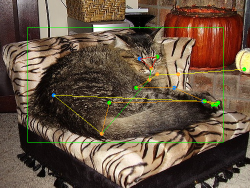

In [21]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
local_runtime = False
from xtcocotools.coco import COCO
from mmcv import Config
from mmpose.datasets import DatasetInfo
import cv2

try:
  from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
  local_runtime = True


# initialize pose model
pose_config = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
pose_checkpoint = 'work_dirs/res50_cats_128x128/latest.pth'
# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)

# Use coco api to read the validation set 
coco = COCO('data/cats/annotations/val.json')
img_keys = list(coco.imgs.keys())
image_id =  img_keys[-1]
image = coco.loadImgs(image_id)[0]
image_name = os.path.join('data/cats/images', image['file_name'])
ann_ids = coco.getAnnIds(image_id)

config = Config.fromfile(
    './configs/_base_/datasets/cats.py'
)
dataset = pose_model.cfg.data['test']['type']
dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
if dataset_info is None:
    warnings.warn(
        'Please set `dataset_info` in the config.'
        'Check https://github.com/open-mmlab/mmpose/pull/663 for details.',
        DeprecationWarning)
else:
    dataset_info = DatasetInfo(dataset_info)


# make bounding boxes
box_results = []
for ann_id in ann_ids:
    item = {}
    ann = coco.anns[ann_id]
    # bbox format is 'xywh'
    item['bbox'] = ann['bbox']
    box_results.append(item)

# test a single image, with a list of bboxes
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    image_name,
    box_results,
    bbox_thr=None,
    format='xywh',
    dataset='AnimalCatsDataset',
    dataset_info=dataset_info)


# show pose estimation results
vis_result = vis_pose_result(pose_model,
                             image_name,
                             pose_results,
                             kpt_score_thr=0.,
                             dataset='AnimalCatsDataset',
                             show=False)

# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

if local_runtime:
  from IPython.display import Image, display
  import tempfile
  import os.path as osp
  import cv2
  with tempfile.TemporaryDirectory() as tmpdir:
    file_name = osp.join(tmpdir, 'pose_results.png')
    cv2.imwrite(file_name, vis_result)
    display(Image(file_name))
else:
  cv2_imshow(vis_result)

#### Test

In [22]:
from mmpose.datasets import build_dataset, build_dataloader
from mmpose.models import build_posenet
from mmpose.apis import single_gpu_test
from mmcv.parallel import MMDataParallel
from mmcv.runner import load_checkpoint
import os
import mmcv

# build dataset
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
test_loader_cfg = {**dict(shuffle=False, drop_last=False), 
              **dict(workers_per_gpu=cfg.data.get('workers_per_gpu', 1)),
              **dict(samples_per_gpu=cfg.data.get('samples_per_gpu', 1)),
              **cfg.data.get('test_dataloader', {})
             }
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build model
model = build_posenet(cfg.model)
model = MMDataParallel(model, device_ids=[0])
load_checkpoint(model, os.path.join(cfg.work_dir, "latest.pth"), map_location='cpu')

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
outputs = single_gpu_test(model, data_loader)
dataset.evaluate(outputs, cfg.work_dir)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
=> num_images: 200
=> load 223 samples
load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth


2022-03-20 15:43:33,742 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

load checkpoint from local path: work_dirs/res50_cats_128x128/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 24.0 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.75      | 

OrderedDict([('AP', 0.0),
             ('AP .5', 0.0),
             ('AP .75', 0.0),
             ('AP (M)', 0.0),
             ('AP (L)', 0.0),
             ('AR', 0.0),
             ('AR .5', 0.0),
             ('AR .75', 0.0),
             ('AR (M)', 0.0),
             ('AR (L)', 0.0)])

#### For submission
Finally, you should submit the training config file, model checkpoint, the training logs. They can be found in the work_dir. TA will running model inference on the test set, and use the mAP of the test set for final performance ranking.

In the following, I will show how to prepare the files for submission.

In [23]:
%cd ..
# change "123456" to your student ID
%mkdir 3035915060
%cd 3035915060
%mkdir models
%mkdir codes
%cp ../mmpose/work_dirs/res50_cats_128x128/latest.pth ./models/model.pth # model checkpoint (choose the model you like.)
%cp ../mmpose/work_dirs/res50_cats_128x128/None.log.json ./models/ # training log
%cp ../mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py ./models/ # config file 
%cp ../Cat_pose.ipynb ./codes/Cat_pose.ipynb
%cp ../mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py ./codes/mmpose/configs/res50_cats_128x128.py
%cp ../mmpose/work_dirs/res50_cats_128x128/result_keypoints.json ./ # Result json on the test set
# You also need to prepare the final report.pdf


# You also need to upload the codes and a simple README.txt describing which files are changed.
# NOTICE! Do NOT upload the dataset and the work_dirs. They are too large.

/userhome/cs/nickwang
/userhome/cs/nickwang/3035915060
cp: cannot create regular file './codes/': Not a directory
cp: cannot create regular file './codes/mmpose/configs': No such file or directory
